In [41]:
import sys
import pandas as pd
import numpy as np

sys.path.append('/home/yuliya/repos/cosybio/FedProt/evaluation_utils/')
from evaluation import evaluation_func as fp_eval

from collections import OrderedDict

In [42]:
color_dict = OrderedDict()

color_dict["Methods"] = OrderedDict({
    "FedProt":"black",
    "Fisher":"#E69F00",
    "Stouffer":"#D44400",
    "REM":"#009E73",
    "RankProd":"#2E5EAA"
})

# Read results

In [43]:
dfs = {}

workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Bacterial dataset"] = df
print(f"Proteins: {len(df)}")


workdir = "/home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results" 
df = fp_eval.read_results(workdir,
                          deqms_name="/central_res.tsv",
                          fedprot_name="/DPE.csv")
dfs["Human plasma dataset"] = df
print(f"Proteins: {len(df)}")

Results loaded for DEqMS with 2862 proteins.
Results loaded for FedProt with 2862 proteins.
Results loaded for Fisher with 2823 proteins.
Results loaded for REM with 3020 proteins.
Results loaded for Stouffer with 2511 proteins.
Results loaded for RankProd with 2511 proteins.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/bacterial/balanced/results with 2236 genes. Adj.p-values were not log-transformed.
Results loaded for DEqMS with 532 proteins.
Results loaded for FedProt with 532 proteins.
Results loaded for Fisher with 432 proteins.
Results loaded for REM with 591 proteins.
Results loaded for Stouffer with 471 proteins.
Results loaded for RankProd with 471 proteins.
Results loaded from /home/yuliya/repos/cosybio/FedProt/evaluation/TMT_data/01_smaller_lib_balanced_PG_MajorPG/results with 354 genes. Adj.p-values were not log-transformed.


Proteins: 2236
Proteins: 354


In [44]:
log_dfs = {}
for k in dfs:
    df = dfs[k]
    df = df.replace(0,1e-300)
    df["pv_DEqMS"] = -np.log10(df["pv_DEqMS"])
    for m in ["FedProt", "Fisher","Stouffer","REM","RankProd"]:
        df["pv_"+m] = -np.log10(df["pv_"+m])
    log_dfs[k] = df

# Stats calculation

In [45]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

for dataset in dfs:

    pval_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset], 
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="pv_",
        top_genes=-1
    )
    logfc_basic_stats = fp_eval.calc_stats(
        log_dfs[dataset],
        lfc_thr=0.58, adj_pval_thr=0.01,
        stats=["MinDiff", "MeanDiff", "MaxDiff", "r", "ρ", "NRMSE"],
        methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
        column_name="lfc_",
        top_genes=-1
    )

    pval_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_pval_basic_stats.csv')
    logfc_basic_stats.to_csv(f'{root_dir}/tables/{dataset}_logfc_basic_stats.csv')

    print(f'Dataset: {dataset}')
    print("\tLogFC basic stats:")
    print(logfc_basic_stats)
    print("\tP-value basic stats:")
    print(pval_basic_stats)        

Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.
Correlations computed for all genes from lfc_ columns.
Calculating corrs. Using p-vals - log-transformed.
Correlations computed for all genes from pv_ columns.
RMSE and NRMSE computed for all genes from lfc_ columns.


Correlations computed for all genes from lfc_ columns.


Dataset: Bacterial dataset
	LogFC basic stats:
               MinDiff      MeanDiff       MaxDiff         r         ρ  \
FedProt   0.000000e+00  1.264469e-14  6.039613e-14  1.000000  1.000000   
Fisher    1.598721e-14  2.403312e-03  1.408515e-01  0.999922  0.999867   
Stouffer  1.598721e-14  2.403312e-03  1.408515e-01  0.999922  0.999867   
REM       1.809160e-07  1.438659e-02  2.087504e-01  0.999419  0.998227   
RankProd  2.182789e-06  2.480047e-03  1.408515e-01  0.999914  0.999865   

                 NRMSE  
FedProt   2.026967e-15  
Fisher    1.108093e-03  
Stouffer  1.108093e-03  
REM       3.020795e-03  
RankProd  1.162811e-03  
	P-value basic stats:
           MinDiff   MeanDiff     MaxDiff         r         ρ
FedProt   0.000000   0.000091    0.000354  1.000000  1.000000
Fisher    0.001350   4.848323   31.460832  0.980720  0.956496
Stouffer  0.000665   4.099756   27.489890  0.988371  0.964883
REM       0.000330  16.611312  262.957151  0.766566  0.907347
RankProd  0.001094  16.585

Plotting corrs using p-vals - log-transformed.


Bacterial dataset           Human plasma dataset          
                         r         ρ                    r         ρ
FedProt           1.000000  1.000000             1.000000  1.000000
Fisher            0.980714  0.956248             0.963843  0.899812
Stouffer          0.988368  0.964654             0.964835  0.865684
REM               0.766578  0.907471             0.878816  0.941733
RankProd          0.778059  0.869386             0.773119  0.890968

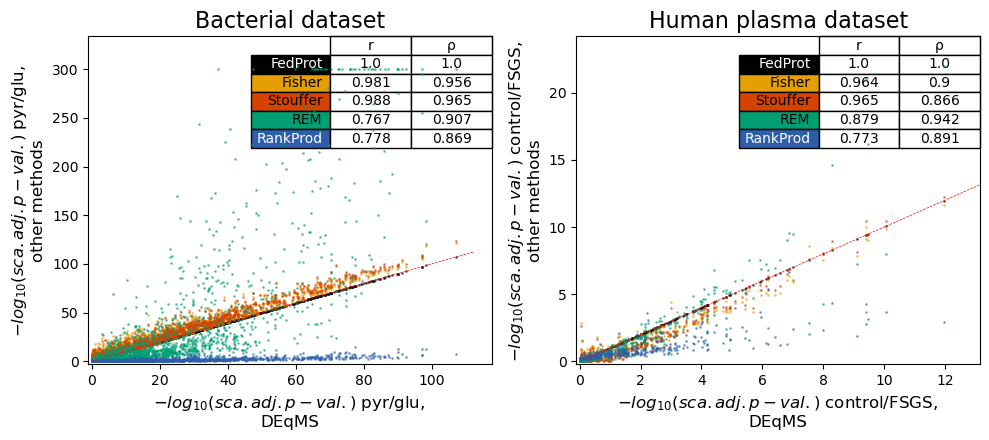

In [46]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="pv_", 
    text="", dotsize=1,
    datasets=list(log_dfs.keys()),
    add_table=True,
    sharex=False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

Plotting corrs using logFC values.


Bacterial dataset           Human plasma dataset          
                         r         ρ                    r         ρ
FedProt           1.000000  1.000000             1.000000  1.000000
Fisher            0.999922  0.999866             0.998739  0.998417
Stouffer          0.999922  0.999866             0.998739  0.998417
REM               0.999419  0.998226             0.995871  0.995475
RankProd          0.999914  0.999865             0.998662  0.998126

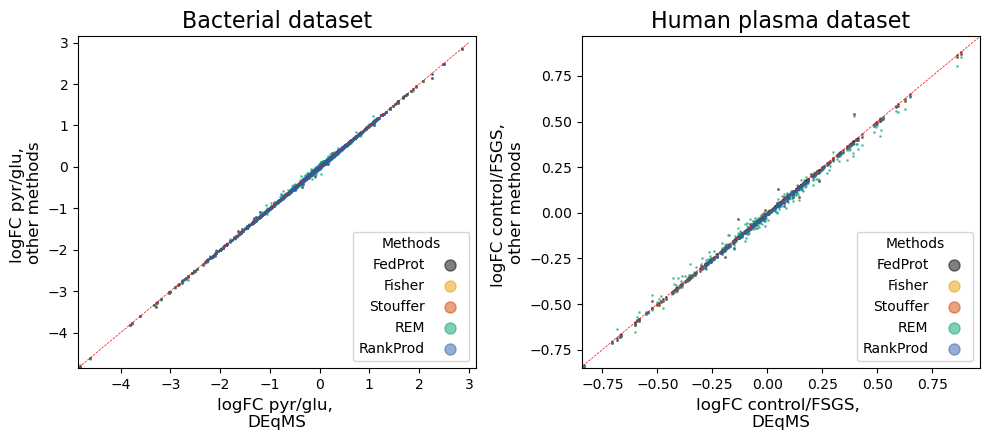

In [47]:
fp_eval.plt_results(
    log_dfs, 
    methods=["FedProt","Fisher","Stouffer","REM","RankProd"],
    color_dict=color_dict,
    what="lfc_", 
    text="", dotsize=1,
    datasets=list(log_dfs.keys()),
    add_table=False,
    sharex=False, sharey=False,
    comparsions=["pyr/glu", "control/FSGS"]
)

# plt.savefig("/home/yuliya/repos/cosybio/FedDEqMS/data/04_evaluation/plots/" + "Fig3B_prototype.png", dpi=1200)

In [48]:
root_dir = "/home/yuliya/repos/cosybio/FedProt/evaluation/aggregated_eval"

fp_fn_b = fp_eval.calc_stats(
    log_dfs["Bacterial dataset"], 
    lfc_thr=0.5, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_h = fp_eval.calc_stats(
    log_dfs["Human plasma dataset"], 
    lfc_thr=0.25, adj_pval_thr=0.05,
    stats=["FP", "FN", "Jaccard"],
    methods=["FedProt", "Fisher", "Stouffer", "REM", "RankProd"],
    column_name="pv_",
    top_genes=-1
)

fp_fn_b.to_csv(f'{root_dir}/tables/Bacterial_FP_FN.csv')
fp_fn_h.to_csv(f'{root_dir}/tables/Human_FP_FN.csv')

print("\tFP/FN bacterial dataset:")
print(fp_fn_b)  
print("\tFP/FN human plasma dataset:")
print(fp_fn_h)

Performance metrics calculated for all genes.


Performance metrics calculated for all genes.


	FP/FN bacterial dataset:
           FP    FN   Jaccard
FedProt   0.0   0.0  1.000000
Fisher    1.0   1.0  0.996650
Stouffer  1.0   1.0  0.996650
REM       6.0  12.0  0.970100
RankProd  0.0  83.0  0.860738
	FP/FN human plasma dataset:
           FP    FN   Jaccard
FedProt   0.0   0.0  1.000000
Fisher    2.0   6.0  0.922330
Stouffer  2.0  13.0  0.854369
REM       1.0  13.0  0.862745
RankProd  0.0  29.0  0.712871


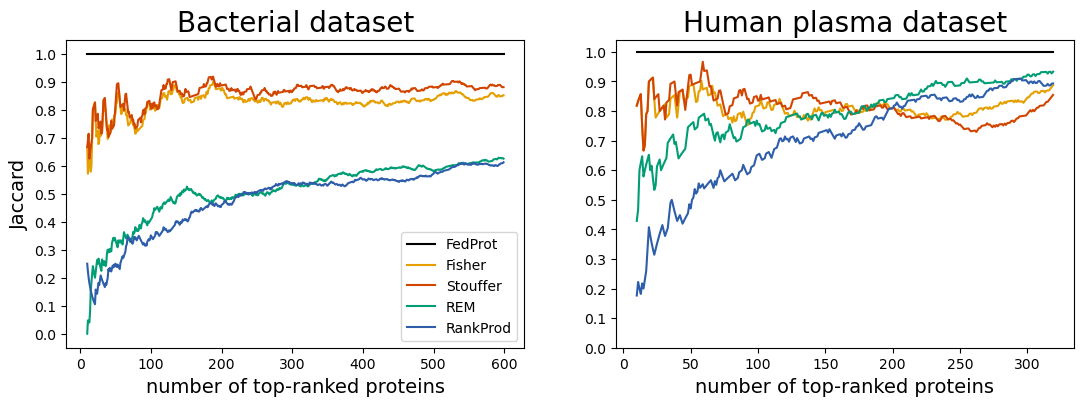

In [56]:
min_n_genes = 10
step = 1

data = fp_eval.plot_stats_for_topN(
    log_dfs,
    datasets = list(log_dfs.keys()),
    methods=["FedProt", "Fisher","Stouffer","REM", "RankProd"],
    metrics=["Jaccard"],
    min_n_genes=min_n_genes,
    max_n_genes=[600, 320],
    step=step,
    color_dict=color_dict,
    sharey=False,
    )